In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy as sp
from skimage import data, io, filters
from skimage.color import rgb2hsv, hsv2rgb, xyz2rgb
from skimage import data, img_as_float
from skimage import exposure

from lippmann import show_spectrum, show_lippmann_transform, lippmann_transform
from display_spectral_data import load_specim_data
from color_tools import upsample_hue_saturation, from_spectrum_to_xyz, from_xyz_to_rgb
from spectrum import Spectrum3D
import spectrum_recovery_pool as recov

/home/miska/Lippmann/lippmann/display_spectral_data.py:23: UserWarning: No module named 'osgeo'
  warnings.warn(gdal_import_error.msg)


### Warning: data has to be downloaded from SWITCH drive (shared by Arnaud)

In [138]:
name = "saasfee" # prefix of the file with data and results 

# directory = "visible_only"
# directory = "visible_high_res_100"
directory = "4" # name of the directory in which the results are stored (number o string)

results_path = f"PNAS/{directory}/{name}"

c0 = 299792458
n0 = 1.5
c = c0 / n0

result = np.load(f"{results_path}.npy")
negative_rato = np.min(result)/np.max(result)
if negative_rato < 0:
    print(f"there are negative values in power spectrum of magnitude {negative_rato}")
result = np.clip(result, a_min = 0, a_max = np.inf)
with open(f"{results_path}.pkl", "rb") as pickled_params:
    params = pickle.load(pickled_params)

if "downsampling" in params:
    ds = params["downsampling"]
else:
    ds = 25
    
# if the data is stored in "Cubes"     
downsampled, wavelengths = load_specim_data("Cubes/" + name, ds, cut=True)

omegas_rec = 2 * np.pi * c / wavelengths
if params["visible"]: #TODO what should be there? 
    omegas_est = np.linspace(2 * np.pi * c / 400E-9, 2 * np.pi * c / 700E-9, result.shape[2])
    print("Restricting spectrum to visible")
else:   
    omegas_est = np.linspace(np.max(omegas_rec), np.min(omegas_rec), result.shape[2])
wavelengths_est = 2 * np.pi * c / omegas_est

there are negative values in power spectrum of magnitude -0.064800317560282
Restricting spectrum to visible


In [139]:
print("Experiment setup")
print_params = params.copy()

Z = params["Z"]
k0 = params["k0"]

if "estimate_depth" in params:
    if params["estimate_depth"]:
        plt.matshow(params["Z_estimates"])
        plt.colorbar()
        plt.savefig(f"{results_path}_z.pdf")
        plt.show()
        print_params.pop("Z_estimates")
        print_params.pop("k0_estimates")
        Z = np.median(params['Z_estimates'])
        k0 = np.median(params["k0_estimates"])
        print(f"median depth {Z:.2e}")
        print(f"median decay {k0}")
print_params.pop("errors")
print_params

Experiment setup


{'N': 200,
 'Z': 2.76e-06,
 'k0': 3.42,
 'r': (-0.5936336673094982+0.3709434849632434j),
 'n_iter': 300,
 'visible': True,
 'downsampling': 25,
 'estimate_depth': False,
 'stop_error': 0.005,
 'c': 199861638.66666666,
 'mask_purple': True}

In [140]:
# result_low_res = np.load(f"{results_path}_low_res.npy")
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4))
# print(result_low_res.shape)
# ax1.plot(result_low_res[0, 0])
# ax1.axhline(0)

# F = recov.generate_matrix_F(omegas_est, Z)
# ax2.plot(F @ result_low_res[0, 0])
# ax2.axhline(0)
# plt.show()

/home/miska/system/anaconda3/envs/lippmann/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


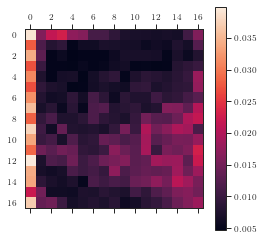

In [141]:
plt.matshow(params["errors"])
plt.colorbar()
plt.show()

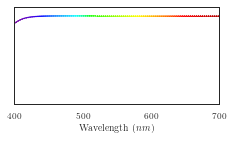

In [154]:
pixel = (6, 6)


def sigmoid(x):
    return 1 / (3 + np.exp(-x))

mask = np.linspace(1, 50, len(wavelengths))
mask = sigmoid(mask)
plt.figure()
plt.gca().axhline()
show_spectrum(wavelengths, mask, visible=True, ax=plt.gca())

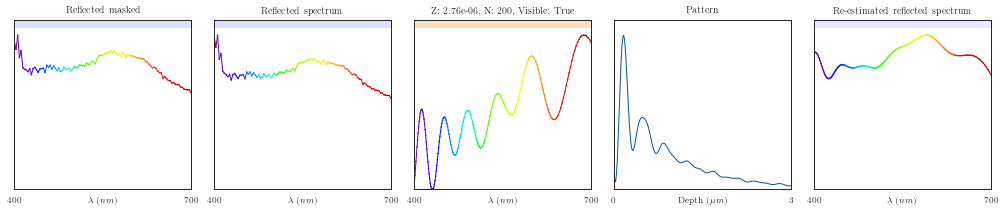

In [155]:
A = recov.generate_matrix_A(omegas_est, Z, r=params["r"], k0=k0)

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(14, 3))

show_spectrum(wavelengths, mask*downsampled[pixel], show_background=True, short_display=True, ax=ax0, visible=True)
show_spectrum(wavelengths, downsampled[pixel], show_background=True, short_display=True, ax=ax1, visible=True)
show_spectrum(wavelengths_est, result[pixel], show_background=True, short_display=True, ax=ax2, visible=True)

depths = np.linspace(0,Z,200)
show_lippmann_transform(depths, lippmann_transform(wavelengths_est, result[pixel], depths, r=params["r"], k0=k0)[0], ax=ax3, short_display=True)

show_spectrum(wavelengths_est, np.abs(A @ result[pixel])**2, show_background=True, short_display=True, ax=ax4, visible=True)
ax1.set_title("Reflected spectrum")
title = f"Z: {params['Z']}, N: {params['N']}, Visible: {params['visible']}"
if "estimate_depth" in params and params["estimate_depth"]:
    title += f", Z est: {params['Z_estimates'][pixel]:.2e}"
ax2.set_title(title)
ax3.set_title("Pattern")
ax4.set_title("Re-estimated reflected spectrum")
ax0.set_title("Reflected masked")
# plt.savefig(f"{results_path}_point.pdf")
plt.show()

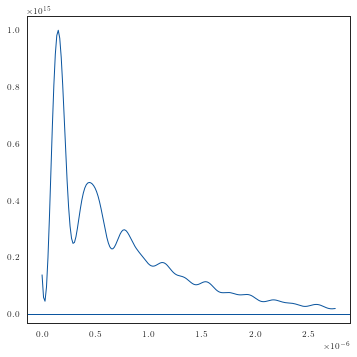

In [156]:
plt.figure(figsize=(5,5))
plt.plot(depths, lippmann_transform(wavelengths_est, result[pixel], depths, r=params["r"], k0=k0)[0])
plt.gca().axhline(0)
plt.show()

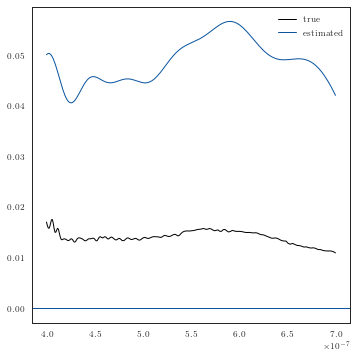

In [157]:
spectrum = sp.interpolate.interp1d(omegas_rec, mask*downsampled[pixel], kind='cubic', bounds_error=False, 
                                   fill_value='extrapolate')(omegas_est)
plt.figure(figsize=(5,5))
plt.plot(wavelengths_est, spectrum, label="true", c="k")
plt.plot(wavelengths_est, np.abs(A @ result[pixel])**2, label="estimated")
plt.gca().axhline()
plt.legend()
plt.show()

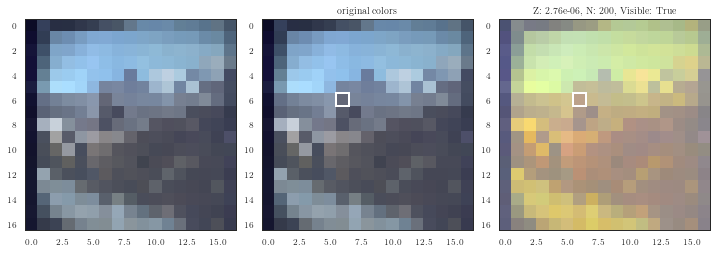

array([0.38793239, 0.40151073, 0.46597339])

In [158]:
from matplotlib.patches import Rectangle
import copy

downsampled_no_blue = downsampled * mask[None, None, :]

def spectrum_to_rgb(wavelengths, spectrum):
    spectrum_xyz = from_spectrum_to_xyz(wavelengths, spectrum, normalize=False)
    spectrum_xyz = spectrum_xyz / np.min(np.sum(spectrum_xyz, axis=2))
    return from_xyz_to_rgb(spectrum_xyz)

no_blue_rgb = spectrum_to_rgb(wavelengths, downsampled_no_blue)
recorded_rgb = spectrum_to_rgb(wavelengths, downsampled)
estimated_rgb = spectrum_to_rgb(wavelengths_est, result)


fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5))
ax0.imshow(no_blue_rgb)
ax1.imshow(recorded_rgb)
ax2.imshow(estimated_rgb)
ax1.set_title("original colors")
ax2.set_title(title)
rect = Rectangle((pixel[1] - 0.5, pixel[0] - 0.5), 1, 1, alpha=1, color="none", ec="white", lw=2,zorder=10)
rect2 = Rectangle((pixel[1] - 0.5, pixel[0] - 0.5), 1, 1, alpha=1, color="none", ec="white", lw=2,zorder=10)
ax1.add_patch(rect)
ax2.add_patch(rect2)
plt.savefig(f"{results_path}_low_res.pdf")
plt.show()

recorded_rgb[pixel]

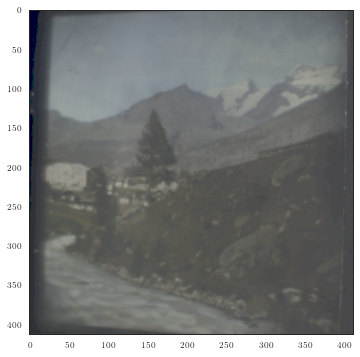

In [159]:
image = io.imread("Cubes/" + name + ".png")
image = np.swapaxes(image[:, ::-1, :3], 1, 0)
cut_idx = np.loadtxt("Cubes/" + name + "_cut.txt").astype(np.int)
image = image[cut_idx[0, 0]:cut_idx[0, 1], cut_idx[1, 0]:cut_idx[1, 1]]

image = exposure.adjust_gamma(image, 0.3)
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.show()

In [151]:
recorded_upsampled = upsample_hue_saturation(image, recorded_rgb, order=1)
estimated_upsampled = upsample_hue_saturation(image, estimated_rgb, order=1)

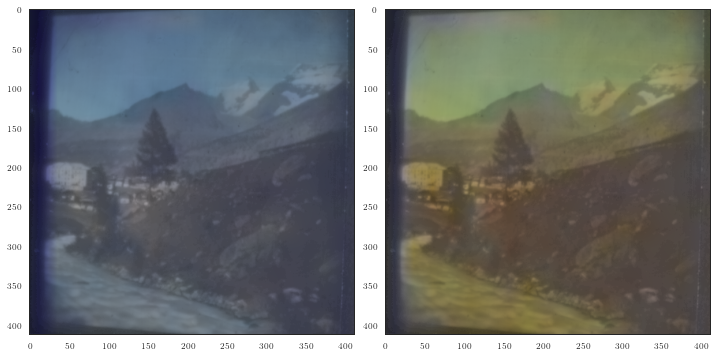

In [152]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(recorded_upsampled)
ax2.imshow(estimated_upsampled)
plt.show()